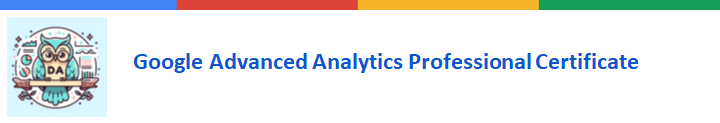

### Dealing With Outliers

Identify Understand and Analyze Outlier impact

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt

In [2]:
# Read the dataset

df = pd.read_csv('/kaggle/input/outliers-dataset/eda_outliers_dataset1.csv')

In [3]:
# Print the first 10 rows
df.head(10)

,year,number_of_strikes
0,2020,15620068
1,2019,209166
2,2018,44600989
3,2017,35095195
4,2016,41582229
5,2015,37894191
6,2014,34919173
7,2013,27600898
8,2012,28807552
9,2011,31392058


We need to create a function to make the number_of_strikes values more readable, let's create a function:

In [4]:
# Creating a function to make numbers readable
# Use a DOCSTING which is a line of text following a method or function that is used to
# explain to others, using your code, what this method or function does. 
# A docstring represents good documentation practice in Python

def readable_numbers(x):
    """takes a large number and formats it into K,M to make it more readable"""
    if x >= 1e6:
        s = '{:1.1f}M'.format(x*1e-6)
    else:
        s = '{:1.0f}K'.format(x*1e-3)
    return s

# Use the readable_numbers() function to create a new column
df['number_of_strikes_readable']=df['number_of_strikes'].apply(readable_numbers)

In [5]:
df.head(10)

,year,number_of_strikes,number_of_strikes_readable
0,2020,15620068,15.6M
1,2019,209166,209K
2,2018,44600989,44.6M
3,2017,35095195,35.1M
4,2016,41582229,41.6M
5,2015,37894191,37.9M
6,2014,34919173,34.9M
7,2013,27600898,27.6M
8,2012,28807552,28.8M
9,2011,31392058,31.4M


One way to find the outliers would be to investigate the mean and the media of the dataset


In [6]:
print("Mean:" + readable_numbers(np.mean(df['number_of_strikes'])))
print("Median:" + readable_numbers(np.median(df['number_of_strikes'])))

Mean:26.8M
Median:28.3M


because of the mean being 2 million less than the median value, we suspect that the data distribution is skewed to the left

One effective way to visualize outliers is a boxplot, the purpose of a boxplot is to show the distribution of values, separated into quadrants or quartiles

<ipython-input-7-340e5da381ac>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  box.set_xticklabels(np.array([readable_numbers(x) for x in g.get_xticks()]))


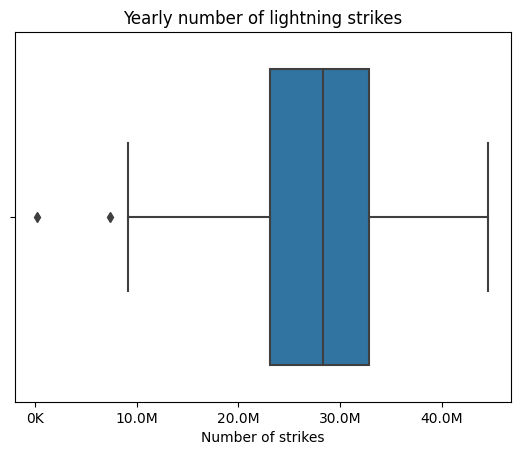

In [7]:
#Create a boxplot
box = sns.boxplot(x=df['number_of_strikes'])
g = plt.gca()
box.set_xticklabels(np.array([readable_numbers(x) for x in g.get_xticks()]))
plt.xlabel('Number of strikes')
plt.title('Yearly number of lightning strikes');


this data visualization is showing us very clearly that there are outliers included in our group of datapoints, the blue rectangles in the boxplot chart are the inter quartile range
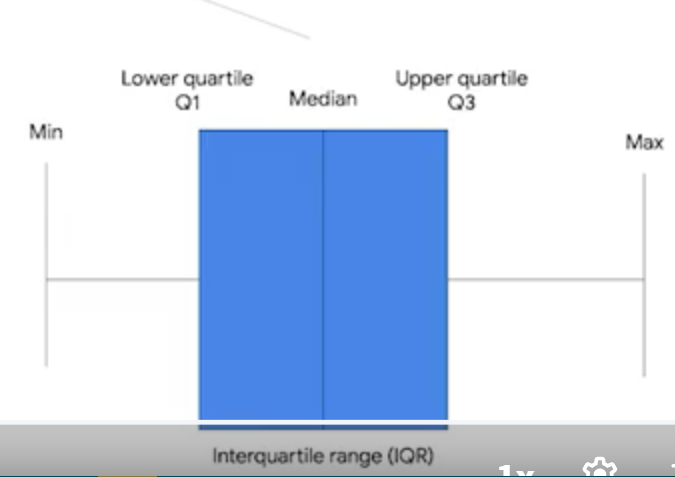

any data point that falls beyond 1.5 times the blue boxes are considered outliers. This next piece of code will help us define what value is at 1.5 times below our interquartile range. We'll use the quantile function to define what we'll call percentile 25 and percentile 75. We enter our data column, number of strikes for our DataFrame, and then 0.25, and 0.75 in the argument fields. The values that occur between the 75th and 25th percentile are the interquartile range. We create a statement for interquartile range, IQR, defining percentile 75 minus percentile 25 is equal to IQR. Now, let's define two statements; upper limit and lower limit. Upper limit is equal to percentile 75 plus 1.5 times IQR. Lower limit is percentile 25 minus 1.5 times the IQR. Lastly, let's have Python provide the exact value of the lower limit.

In [8]:
# Calculate 25th percentile of annual striles
percentile25 = df['number_of_strikes'].quantile(0.25)

# Claculate 75th percentile of annual strikes
percentile75 = df['number_of_strikes'].quantile(0.75)

# Calculate interquartile range
iqr = percentile75 - percentile25

# Calculate upper and lower thresholds for outliers
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print('Lower limit is: '+ readable_numbers(lower_limit))

Lower limit is: 8.6M


let's plot the values that fall below the lower limit

In [9]:
# Isolate outliers on low end
df[df['number_of_strikes'] < lower_limit]


,year,number_of_strikes,number_of_strikes_readable
1,2019,209166,209K
33,1987,7378836,7.4M


These years are the outliers. let's use a data visualization, let's use a scatter plot which represents relationships between different variables with individual data points without a connecting line.



In [10]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i]-0.5, y[i]+0.05, s=readable_numbers(y[i]))
        

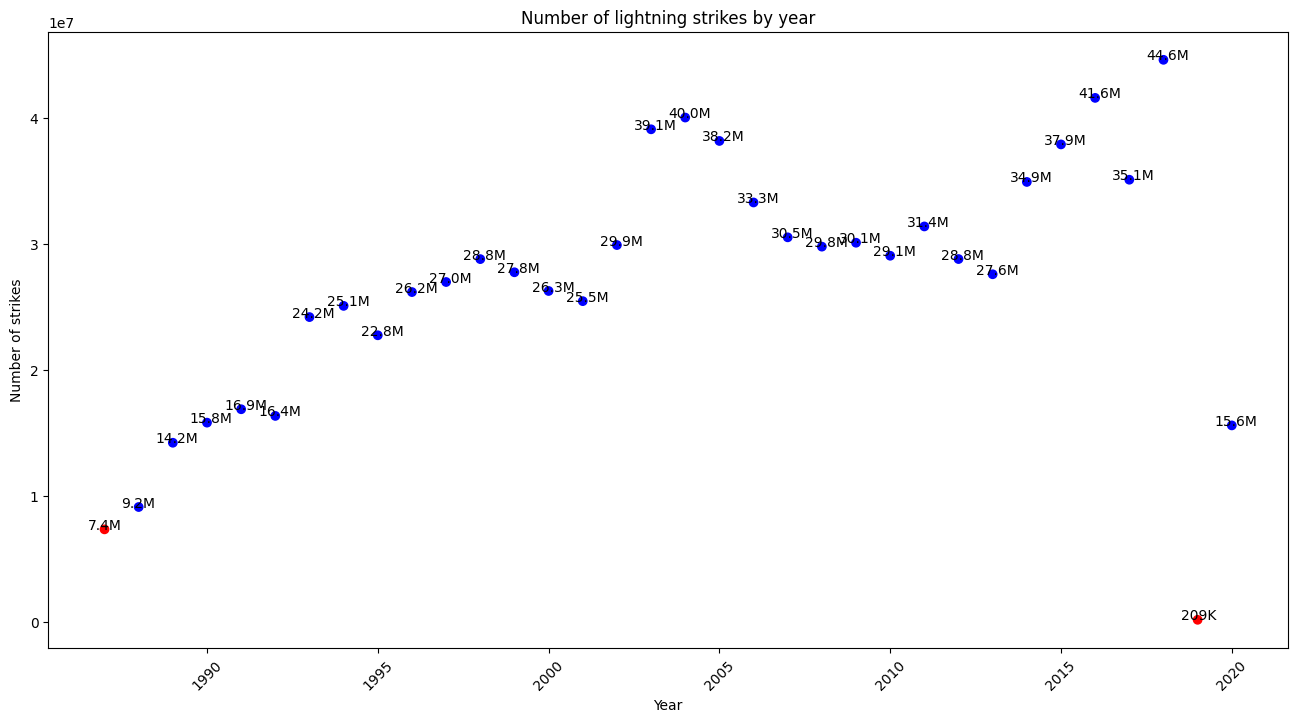

In [11]:
colors = np.where(df['number_of_strikes'] <lower_limit, 'r', 'b')

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['year'], df['number_of_strikes'],c=colors)
ax.set_xlabel('Year')
ax.set_ylabel('Number of strikes')
ax.set_title('Number of lightning strikes by year')
addlabels(df['year'], df['number_of_strikes'])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.show()

We can see that the values for 1987 and 2019 marked in red, are two outliers. We have narrowed it down. Now lets do a little bit more investigation

In [12]:
df_2019 = pd.read_csv('/kaggle/input/outliers-dataset/eda_outliers_dataset2.csv')
df_2019.head()


,date,number_of_strikes,center_point_geom
0,2019-12-01,1,POINT(-79.7 35.3)
1,2019-12-01,1,POINT(-84.7 39.3)
2,2019-12-01,1,POINT(-83.4 38.9)
3,2019-12-01,1,POINT(-71.5 35.2)
4,2019-12-01,1,POINT(-87.8 41.6)


In [13]:
# Convert the 'date' column to datetime

df_2019['date']= pd.to_datetime(df_2019['date'])

In [14]:
# Create 2 new columns
df_2019['month'] = df_2019['date'].dt.month
df_2019['month_txt'] = df_2019['date'].dt.month_name().str.slice(stop=3)

# Group by 'month' and 'month_txt', sum it, and sort. Assign result to new df
df_2019_by_month = df_2019.groupby(['month', 'month_txt']).sum(numeric_only=True).sort_values('month', ascending=True).head(12)
df_2019_by_month

,,number_of_strikes
month,month_txt,
12,Dec,209166


for the 2019 dataset, only values for the month of december have been captured. that is why readings are so low for 2019. that is the explanation. now lets check the year 1987

In [15]:
# Read in 1987 data
df_1987 = pd.read_csv('/kaggle/input/outliers-dataset/eda_outliers_dataset3.csv')

# Convert 'date' column to datetime
df_1987['date'] = pd.to_datetime(df_1987['date'])

# Create 2 new columns
df_1987['month'] = df_1987['date'].dt.month
df_1987['month_txt'] = df_1987['date'].dt.month_name().str.slice(stop=3)

# Group by 'month' and 'month_txt', sum it, and sort. Assign result to new df
df_1987_by_month = df_1987.groupby(['month', 'month_txt']).sum(numeric_only=True).sort_values('month', ascending=True).head(12)
df_1987_by_month

,,number_of_strikes
month,month_txt,
1,Jan,23044
2,Feb,61020
3,Mar,117877
4,Apr,157890
5,May,700910
6,Jun,1064166
7,Jul,2077619
8,Aug,2001899
9,Sep,869833


The year 1987 has values captured for all the months. For the case of 2019 it would make sense to remove the year from the study because of insufficient values. as for 1987 it is indeed an outlier but it should not be excluded for our analysis because is has values captured for all the months of the year.


Now let's take a look at the mean and the median of the dataset excluding the outliers

In [16]:
# Create new df that removes outliers
df_without_outliers = df[df['number_of_strikes'] >= lower_limit]

# Recalculate mean and median values on data without outliers
print("Mean:" + readable_numbers(np.mean(df_without_outliers['number_of_strikes'])))
print("median:" + readable_numbers(np.median(df_without_outliers['number_of_strikes'])))

Mean:28.2M
median:28.8M


the mean and median are fairly close together, suggesting an evenly distributed dataset